In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm


# Data analysis

In [2]:
df = pd.read_csv('./datasets/all_steps_test_paper.csv')
#df = pd.read_csv('./datasets/all_steps.csv')
tgn = 4
df = df.loc[df['tangram nr' ] ==tgn]

#this removes steps that are outside the grid (backtracks)
df=df[df.step != 100]


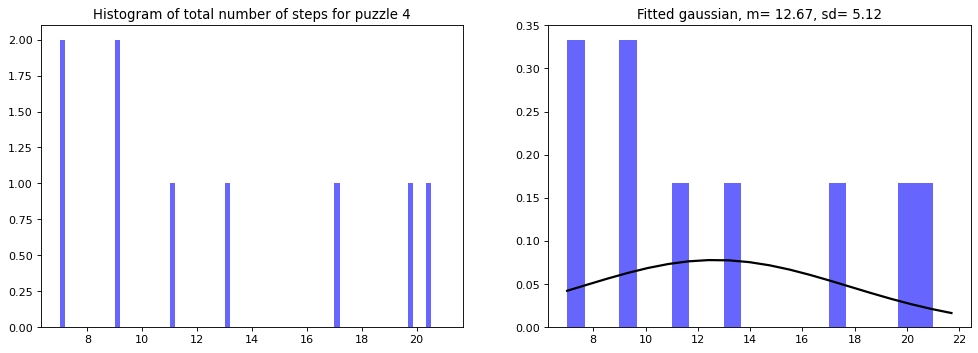

In [3]:
#df = pd.read_csv('./datasets/steps_test.csv')


participants = df.groupby(['sid','tangram nr']).max()['step'].to_numpy()

data = participants
plt.figure(figsize=(15, 5), dpi=80)
ax = plt.subplot(121)
ax.set_title(f'Histogram of total number of steps for puzzle {tgn}')
# H, bins = np.histogram(data,bins=int(np.max(data)))

# ax.bar(bins[:-1],H,width=0.5)
ax.hist(data, bins=int(np.max(participants)), alpha=0.6, width=0.2, color='b')
ax = plt.subplot(122)
mu, std = norm.fit(data)

ax.hist(data, bins=int(np.max(participants)), density=True,stacked=True, alpha=0.6, color='b')
xmin, xmax = (7,plt.xlim()[1])
x = np.linspace(xmin, xmax, 20)
p = norm.pdf(x, mu, std)
ax.set_title('Fitted gaussian, m= {:.2f}, sd= {:.2f}'.format(mu,std))
plt.plot(x, p, 'k', linewidth=2)
plt.show()

In [4]:
print('participants pre-trim')
print(f'mean: {participants.mean()}, std: {participants.std()}, max: {participants.max()}')
participants = participants[participants<participants.mean()+3*participants.std()]
print('participants')
l = len(participants)
print('n:%d'%l)
print(f'mean: {participants.mean()}, std: {participants.std()}, max: {participants.max()}')
print('perfect solutions: %.2f'%(np.count_nonzero(participants == 7)/l))
print(np.count_nonzero(participants == 7))

participants pre-trim
mean: 12.666666666666666, std: 5.120763831912406, max: 21.0
participants
n:9
mean: 12.666666666666666, std: 5.120763831912406, max: 21.0
perfect solutions: 0.22
2


# General stats
Avg number of steps, std...

In [5]:
def print_results_1(tgn):
    print(tgn)
    test_data = np.loadtxt(f'datasets/heatmap{tgn}_test.txt')
    train_data = np.loadtxt(f'datasets/heatmap{tgn}.txt')
    #data = np.loadtxt(f'datasets/heatmap{tgn}.txt')
    test_data = np.flip(test_data/test_data.sum(axis=0,keepdims=1),axis=0)
    train_data = np.flip(train_data/train_data.sum(axis=0,keepdims=1),axis=0)
    heatmaps = []
    heatmaps.append(train_data)
    heatmaps.append(test_data)

    for restype in ['balanced','freq','vision']:
        mat = pd.read_csv(f"results/heatmap_{tgn}_{restype}_cnt.csv",header=None).to_numpy()
        solved_at = (mat==0).argmax(axis=1)
        solved_at[solved_at==0] = mat.shape[1] 

        heatmap = np.zeros((5,10))
        for i in range(5):
            p = i+1
            for m in range(10):
                heatmap[i,m] = np.count_nonzero(mat[:,m] == p)
        heatmaps.append(heatmap/heatmap.sum(axis=0,keepdims=1))
        print(f'{restype} -- mean: {solved_at.mean()}, std: {solved_at.std()}, perfect: {np.count_nonzero(solved_at == 7)}:{np.count_nonzero(solved_at == 7)/31}')
        
    fig, axs = plt.subplots(5,1, figsize = (4,20))
    cmap = sns.cm.rocket_r



    for hm,ax,name in zip(heatmaps,axs.flatten(),['training data','test data','balanced','freq','vision']):
        y_axis_labels = ['small triangle','square','parall','middle triangle','big triangle']
        x_axis_labels = [1,2,3,4,5,6,7,8,9,10]
        ax.set_title(name)

        rmse =np.sqrt(np.mean((hm-train_data)**2, axis=0))
        print(f'{name}: {np.mean(rmse)}')

        sns.heatmap(hm,ax=ax,yticklabels=y_axis_labels,xticklabels=x_axis_labels,cmap=cmap,vmin=0, vmax=1)
        ax.invert_yaxis()
    plt.show()

2
balanced -- mean: 10.833333333333334, std: 5.441098745249488, perfect: 10:0.3225806451612903
freq -- mean: 10.266666666666667, std: 5.0985836813330385, perfect: 15:0.4838709677419355
vision -- mean: 10.2, std: 5.455272678794342, perfect: 18:0.5806451612903226
training data: 0.0
test data: 0.13667321810272096
balanced: 0.13606477655088417
freq: 0.14676643386082894
vision: 0.11677991740630245


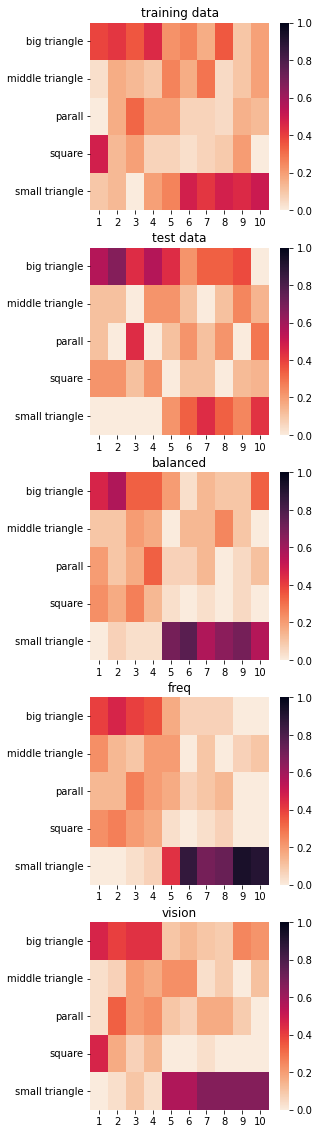

In [6]:
print_results_1(2)

In [7]:
def rot_normalize(pos,piece='square'):
    # normalize position of square and parall
    if pos == 'set()':
        return pos
    else:
        print(pos)
        pos = list(eval(pos))[0][1]
    rot = pos[1]
    if piece =='square':
        if rot% 90 == 0:
            return (pos[0],0)
        else:
            return (pos[0],45)
        
    if piece == 'parall':
        if rot == 180:
            return (pos[0],0)
        if rot == 225:
            return (pos[0],45)
        if rot == 270:
            return (pos[0],90)
        if rot == 315:
            return (pos[0],135)
    return pos

tgn = 4
#users = pd.read_csv('datasets/test_states.csv')
users = pd.read_csv('datasets/train_states.csv')
users = users.loc[users['tangram nr'] ==tgn]
for mtype in ['balanced','freq','vision']:
    model = pd.read_csv(f'results/model_states_evolution_{tgn}_{mtype}_cnt.csv')

    limits = {2:int(10.8+6.9),4:int(12.4+6.5)}
    offset = [1,2,3,3,3]
    score = 0
    max_score = 0
    errors= 0
    for run in model.run.unique():
        run_steps = model.loc[model.run == run]
        if len(run_steps) < 17:
            errors+=1
            continue
        for step in range(3,limits.get(tgn)):


            state = run_steps.iloc[step-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
            previous = run_steps.iloc[step-2][['small triangle','middle triangle','big triangle','square','parallelogram']]
            last_state = run_steps.iloc[-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
            if not (state.equals(last_state) and state.equals(previous)):
                max_score +=1
                users_at_step = users.loc[users['step'].isin(list(range(step-offset[step//4], step + offset[step//4]+1)))][['small triangle','middle triangle','big triangle','square','parallelogram']]
                res= users_at_step.loc[
                    (users_at_step['small triangle'] == state['small triangle']) &
                    (users_at_step['middle triangle'] == state['middle triangle']) &
                    (users_at_step['big triangle'] == state['big triangle']) &
                    (users_at_step['square']== state['square']) &
                    (users_at_step['parallelogram'] == state['parallelogram'])
                ]
                if not res.empty:
                    score+=1
    print(f'model: {mtype}')
    print(f'score: {score} / {max_score}')
    print(f'\t={score/max_score}')


model: balanced
score: 144 / 243
	=0.5925925925925926
model: freq
score: 127 / 217
	=0.5852534562211982
model: vision
score: 146 / 257
	=0.5680933852140078


In [11]:
res= [0.18181818181818182, 0.3125, 0.6, 0.2, 0.6666666666666666, 0.5384615384615384, 0.6666666666666666, 0.625, 0.0, 0.25, 0.8, 0.8, 0.3333333333333333, 0.14285714285714285, 0.375, 0.375, 0.42857142857142855, 0.375, 0.8, 0.5, 0.6, 0.5714285714285714, 0.5714285714285714, 0.6666666666666666, 0.4375, 0.25, 0.2, 0.5555555555555556, 0.6, 0.5333333333333333, 0.375]
np.mean(res)

0.4623157308641179